Note download data from https://drive.google.com/drive/folders/1EgDN57LDuvlZAwr5-eHWB5CTJ7K9HpDP

Credit to this repo: https://github.com/LukasMosser/geolink_dataset

## Data Disclaimer

All the data serving as an input to these notebooks was generously donated by GEOLINK  
and is CC-by-SA 4.0 

If you use their data please reference their dataset properly to give them credit for their contribution.

In [1]:
import lasio
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
from sklearn import preprocessing
from operator import itemgetter

# in and our directories

In [2]:
data_locations = Path(
    "../../data/raw/geolink_dataset/GEOLINK North sea wells with Lithology interpretation/GEOLINK_Lithology and wells NORTH SEA"
)
data_locations_wellheads = Path("../../data/raw/geolink_dataset/norge_well_heads")
interim_locations = Path("../../data/processed/geolink_norge_dataset/")

# load and save as parquet

In [ ]:
df_lithology = pd.read_excel(data_locations / "../Lithology code data.xlsx", header=1)[
    :-1
]
df_lithology["Abbreviation"] = pd.to_numeric(df_lithology["Abbreviation"])
df_lithology.to_parquet(
    interim_locations / "geolink_norge_lithology.parquet", compression="gzip"
)
df_lithology

In [ ]:
df_well_tops = pd.concat(
    [
        pd.read_csv(data_locations_wellheads / "wellbore_exploration_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_development_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_other_all.csv"),
    ]
)
df_well_tops["wlbWellboreName_geolink"] = df_well_tops["wlbWellboreName"].str.replace(
    "/", "_"
)


# add dates
date_cols = ["wlbEntryDate", "wlbCompletionDate"]
for c in date_cols:
    df_well_tops[c] = pd.to_datetime(df_well_tops[c])  # .astype('str')

df_well_tops["wlbNsDecDeg"] = df_well_tops["wlbNsDecDeg"].replace(0, np.nan)
df_well_tops["wlbEwDesDeg"] = df_well_tops["wlbEwDesDeg"].replace(0, np.nan)

a = set(df_well_tops.columns)
df_well_tops = df_well_tops.dropna(axis=1, thresh=0.9 * len(df_well_tops))
b = set(df_well_tops.columns)
print("removed", a - b)

# make into geodataframe
df_well_tops = gpd.GeoDataFrame(
    df_well_tops,
    geometry=gpd.points_from_xy(df_well_tops.wlbEwDesDeg, df_well_tops.wlbNsDecDeg),
)
df_well_tops

## Las files

We can now proceed to import these files as las files and get their dataframes and hopefully put them into a data format that is more suited for ML tasks.

In [ ]:
if not (interim_locations / "geolink_norge_well_logs_raw.parquet").exists():

    # load las files
    well_dataframes = []
    files = sorted(data_locations.glob("*.las"))
    for f in tqdm(files):
        df = lasio.read(f).df()
        df["Well"] = f.stem
        well_dataframes.append(df)

    df_all = pd.concat(well_dataframes)

    df_all["Well"] = df_all["Well"].astype("category")

    # Name lithology
    litho_dict = df_lithology.set_index("Abbreviation")["Lithology"].to_dict()
    df_all["LITHOLOGY_GEOLINK"] = (
        df_all["LITHOLOGY_GEOLINK"].replace(litho_dict).astype("category")
    )

    # unique index
    df_all = df_all.reset_index()  # .set_index(['Well', 'DEPT'])

    df_all.to_parquet(
        interim_locations / "geolink_norge_well_logs_raw.parquet", compression="gzip"
    )

df_all = pd.read_parquet(interim_locations / "geolink_norge_well_logs_raw.parquet")

## Clean las files

In [ ]:
# Clean.

# must have well head
df_all_clean2 = df_all[
    df_all.Well.apply(lambda s: s in set(df_well_tops["wlbWellboreName_geolink"]))
]

# must have lithology
df_all_clean2 = df_all_clean2.dropna(subset=["LITHOLOGY_GEOLINK"])
print("nans", df_all_clean2.isna().mean().sort_values())
# Remove logs which are present less than half the time
df_all_clean1 = df_all_clean2.dropna(axis=1, thresh=0.9 * len(df_all_clean2))
print(f"kept {len(df_all_clean1.columns)/len(df_all_clean2.columns):%} cols")
# Drop columns with Nan's
df_all_clean = df_all_clean1.dropna(axis=0)
print(f"kept {len(df_all_clean)/len(df_all_clean2):%} rows")
df_all_clean

In [ ]:
# Split by well name
wells_val = [
    "35_11-1",
    "35_11-10",
    "35_11-11",
    "35_11-12",
    "35_11-13",
    "35_11-15 S",
    "35_11-2",
    "35_11-5",
    "35_11-6",
    "35_11-7",
    "35_12-1",
]

wells_test = [
    "34_10-12",
    "34_10-16 R",
    "34_10-17",
    "34_10-19",
    "34_10-21",
    "34_10-23",
    "34_10-33",
    "34_10-35",
    "34_10-5",
    "34_10-7",
    "34_11-1",
    "34_11-2 S",
    "34_11-3 T2",
]

In [ ]:
df_all_clean_test = df_all_clean[df_all_clean.Well.apply(lambda s: s in wells_test)]
df_all_clean_train = df_all_clean[
    df_all_clean.Well.apply(lambda s: (s not in wells_test) and (s not in wells_val))
]
assert len(set(df_all_clean_val.Well).intersection(set(df_all_clean_train))) == 0
assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_train))) == 0
assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_val))) == 0
len(df_all_clean_train), len(df_all_clean_val), len(df_all_clean_test)

In [ ]:
df_all_clean_train.to_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet", compression="gzip"
)
df_all_clean_test.to_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet", compression="gzip"
)
df_all_clean_val.to_parquet(
    interim_locations / "geolink_norge_well_logs_val.parquet", compression="gzip"
)

In [ ]:
df_all_clean

# Others

In [ ]:
df_picks = pd.read_excel(
    data_locations / "../NPD stratigraphic picks north sea.xlsx", header=0
)
df_picks.to_parquet(
    interim_locations / "geolink_norge_picks.parquet", compression="gzip"
)

In [ ]:
df_picks

## Well heads part 2

In [ ]:
# only wells we use
a = sorted(df_all.Well.unique())
df_well_tops = df_well_tops[
    df_well_tops["wlbWellboreName_geolink"].apply(lambda s: s in a)
]

In [ ]:
df_well_tops.to_file(interim_locations / "norge_well_tops.gpkg", driver="GPKG")

# Example Load

In [ ]:
# Test load
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
)  # .set_index(['Well', 'DEPT'])

df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
]
df_well_tops.plot()

In [ ]:
# Merge well tops and well logs, a selection
df_all_clean3 = pd.merge(
    left=df_all_clean2.sample(1000),
    right=df_well_tops_minimal,
    left_on="Well",
    right_on="wlbWellboreName_geolink",
    how="left",
).drop(columns="wlbWellboreName_geolink")
df_all_clean3 = df_all_clean3.set_index(['Well', 'DEPT'])
df_all_clean3 = gpd.GeoDataFrame(df_all_clean3, geometry=df_all_clean3['geometry'])
df_all_clean3.plot()
# df_all_clean3

In [ ]:
df_picks = pd.read_parquet(interim_locations / "geolink_norge_picks.parquet")
df_picks

In [ ]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean

# Example plot

In [ ]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean['DEPT'] = df_all_clean.index.get_level_values(1)
df_all_clean

In [ ]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean.xs(well_name)
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)

In [ ]:
plt.figure(figsize=(1,8))
plot_facies(facies)

In [ ]:
plt.figure(figsize=(1,8))
plot_facies(facies, plt.gca(), colorbar=False)

# Xarray

This lets us includes location easily without using much more space

In [3]:
# Load some
df_all_clean1 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean1['Depth'] = df_all_clean1.index.get_level_values(1)
df_all_clean1['split'] = 'test'

# Load some
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean2['Depth'] = df_all_clean2.index.get_level_values(1)
df_all_clean2['split'] = 'train'

# Load some
df_all_clean3 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_val.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean3['Depth'] = df_all_clean3.index.get_level_values(1)
df_all_clean3['split'] = 'val'

df_all = pd.concat([df_all_clean1, df_all_clean2, df_all_clean3])
df_all

LITHOLOGY_GEOLINK       CALI   RHOB         GR  \
Well     DEPT                                                         
34_10-12 1930.174316         Marlstone  12.977000  2.168  39.741283   
         1930.326660         Marlstone  13.273000  2.150  37.034103   
         1930.479126         Marlstone  13.570000  2.137  38.006210   
         1930.631470         Marlstone  14.016000  2.139  39.944405   
         1930.783813         Marlstone  13.883000  2.143  41.935070   
...                                ...        ...    ...        ...   
35_12-1  2999.048096        Silty Sand  11.920000  2.380  87.398651   
         2999.200439        Silty Sand  11.886000  2.373  88.309532   
         2999.352783        Silty Sand  11.913000  2.372  87.673042   
         2999.505371        Silty Sand  11.941000  2.376  88.954941   
         2999.657715        Sandy Silt  11.947001  2.376  86.869347   

                             DTC      RDEP      RMED        Depth split  
Well     DEPT                                                            
34_10-12 1930.174316  131.493591  0.900000  0.893119  1930.174316  test  
         1930.326660  129.506012  0.894000  0.930102  1930.326660  test  
         1930.479126  131.366592  0.894000  0.962067  1930.479126  test  
         1930.631470  128.745590  0.896000  0.983128  1930.631470  test  
         1930.783813  127.375900  0.900000  1.022998  1930.783813  test  
...                          ...       ...       ...          ...   ...  
35_12-1  2999.048096   79.607002  1.635173  0.031000  2999.048096   val  
         2999.200439   78.086998  1.648910  0.031000  2999.200439   val  
         2999.352783   77.822006  1.656949  0.031000  2999.352783   val  
         2999.505371   77.408997  1.648043  0.031000  2999.505371   val  
         2999.657715   77.619003  1.640051  0.031000  2999.657715   val  

[1349252 rows x 9 columns]

In [4]:
df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
].copy()
df_well_tops_minimal['xc'] = df_well_tops_minimal.geometry.x
df_well_tops_minimal['yc'] = df_well_tops_minimal.geometry.y
df_well_tops_minimal

,wlbWellboreName_geolink,wlbCompletionYear,wlbKellyBushElevation,wlbCompletionDate,wlbTotalDepth,geometry,xc,yc
0,6_3-1,1985,23.0,1985-01-02T00:00:00,3560.0,POINT (1.92511 57.96950),1.925106,57.969500
1,6_3-2,1986,22.0,1986-10-03T00:00:00,4091.0,POINT (1.98727 57.90722),1.987275,57.907219
2,7_1-1,1971,34.0,1971-05-08T00:00:00,2808.0,POINT (2.16556 57.79778),2.165556,57.797778
3,7_1-2 S,2008,44.0,2008-08-05T00:00:00,3175.0,POINT (2.06967 57.93252),2.069672,57.932525
4,7_3-1,1969,31.0,1969-10-06T00:00:00,4700.0,POINT (2.74878 57.84313),2.748781,57.843125
...,...,...,...,...,...,...,...,...
216,35_11-15 S,2007,26.0,2007-06-28T00:00:00,3250.0,POINT (3.52221 61.11397),3.522206,61.113967
217,35_12-1,1992,26.0,1992-04-24T00:00:00,3020.0,POINT (3.96261 61.18446),3.962614,61.184461
218,35_12-4 S,2011,29.0,2011-06-26T00:00:00,3585.0,POINT (3.69150 61.18521),3.691500,61.185211
219,36_7-1,1996,22.0,1996-07-05T00:00:00,2841.0,POINT (4.01589 61.35375),4.015894,61.353747


In [5]:
nidx = np.arange(0, 6000, 0.15)

In [17]:
def reindex(x):
    """Reindex each well to 15cm"""
    x = x.reset_index().set_index('DEPT')
    x = x.reindex(nidx, method='nearest', tolerance=0.15, limit=2).drop(columns=['Well']).sort_index()
    return x
#     return x.reset_index().set_index(['Well', 'DEPT'])

df_all3 = df_all.groupby(level=0).apply(reindex).dropna()
df_all3

LITHOLOGY_GEOLINK       CALI      RHOB         GR         DTC  \
Well    DEPT                                                                    
15_9-12 2215.80        Shaly Silt  14.438001  2.363000  60.285748  134.253601   
        2215.95        Shaly Silt  14.438001  2.363000  60.285748  134.253601   
        2216.10        Shaly Silt  14.633000  2.340000  63.250000  129.101868   
        2216.25        Shaly Silt  14.813001  2.314000  61.405998  122.476944   
        2216.40        Shaly Silt  14.383001  2.293000  62.561596  116.908607   
...                           ...        ...       ...        ...         ...   
7_3-1   4569.30  Cross Bedded Sst   8.540000  2.631049  51.219002   63.450794   
        4569.45  Cross Bedded Sst   8.548000  2.626054  51.671001   63.590557   
        4569.60  Cross Bedded Sst   8.552000  2.624065  51.820999   64.036644   
        4569.75  Cross Bedded Sst   8.546000  2.636137  51.327999   64.322495   
        4569.90  Cross Bedded Sst   8.546000  2.636137  51.327999   64.322495   

                     RDEP      RMED        Depth  split  
Well    DEPT                                             
15_9-12 2215.80  0.737006  0.785088  2215.917725  train  
        2215.95  0.737006  0.785088  2215.917725  train  
        2216.10  0.741000  0.840000  2216.070068  train  
        2216.25  0.752000  0.858000  2216.222412  train  
        2216.40  0.739962  0.857046  2216.375000  train  
...                   ...       ...          ...    ...  
7_3-1   4569.30  6.639000  6.690000  4569.305664  train  
        4569.45  6.551000  6.520000  4569.458008  train  
        4569.60  6.464000  6.462185  4569.610352  train  
        4569.75  6.423000  6.439074  4569.762695  train  
        4569.90  6.423000  6.439074  4569.762695  train  

[1303860 rows x 9 columns]

In [18]:
import xarray as xr
xr_all_clean2 = df_all3.to_xarray()
xr_all_clean2

<xarray.Dataset>
Dimensions:            (DEPT: 33501, Well: 183)
Coordinates:
  * Well               (Well) object '15_9-12' '15_9-13' ... '7_1-2 S' '7_3-1'
  * DEPT               (DEPT) float64 2.216e+03 2.216e+03 ... 5.439e+03
Data variables:
    LITHOLOGY_GEOLINK  (Well, DEPT) object 'Shaly Silt' 'Shaly Silt' ... nan nan
    CALI               (Well, DEPT) float64 14.44 14.44 14.63 ... nan nan nan
    RHOB               (Well, DEPT) float64 2.363 2.363 2.34 ... nan nan nan
    GR                 (Well, DEPT) float64 60.29 60.29 63.25 ... nan nan nan
    DTC                (Well, DEPT) float64 134.3 134.3 129.1 ... nan nan nan
    RDEP               (Well, DEPT) float64 0.737 0.737 0.741 ... nan nan nan
    RMED               (Well, DEPT) float64 0.7851 0.7851 0.84 ... nan nan nan
    Depth              (Well, DEPT) float64 2.216e+03 2.216e+03 ... nan nan
    split              (Well, DEPT) object 'train' 'train' 'train' ... nan nan

In [19]:
xr_wells = df_well_tops_minimal.rename(columns={'wlbWellboreName_geolink':'Well'}).set_index('Well').to_xarray()
xr_wells

<xarray.Dataset>
Dimensions:                (Well: 221)
Coordinates:
  * Well                   (Well) object '6_3-1' '6_3-2' ... '36_7-1' '36_7-3'
Data variables:
    wlbCompletionYear      (Well) int64 1985 1986 1971 2008 ... 2011 1996 2002
    wlbKellyBushElevation  (Well) float64 23.0 22.0 34.0 44.0 ... 29.0 22.0 24.0
    wlbCompletionDate      (Well) object '1985-01-02T00:00:00' ... '2002-06-0...
    wlbTotalDepth          (Well) float64 3.56e+03 4.091e+03 ... 2.948e+03
    geometry               (Well) object POINT (1.925106 57.9695) ... POINT (...
    xc                     (Well) float64 1.925 1.987 2.166 ... 3.692 4.016 4.05
    yc                     (Well) float64 57.97 57.91 57.8 ... 61.19 61.35 61.43

In [20]:
xr_all = xr.merge(
    [xr_all_clean2, xr_wells],
    join='left')


In [23]:
xr_all2 = xr_all.sortby(['Well', 'DEPT'])
xr_all2

<xarray.Dataset>
Dimensions:                (DEPT: 33501, Well: 183)
Coordinates:
  * Well                   (Well) object '15_9-12' '15_9-13' ... '7_3-1'
  * DEPT                   (DEPT) float64 412.8 412.9 ... 5.439e+03 5.439e+03
Data variables:
    LITHOLOGY_GEOLINK      (Well, DEPT) object nan nan nan nan ... nan nan nan
    CALI                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RHOB                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    GR                     (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    DTC                    (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RDEP                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RMED                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    Depth                  (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    split                  (Well, DEPT) object nan nan nan nan ... nan nan nan
    wlbCompletionYear      (Well) int64 1982 1982 1982 1982 ... 1971 2008 1969
    wlbKellyBushElevation  (Well) float64 25.0 25.0 25.0 25.0 ... 34.0 44.0 31.0
    wlbCompletionDate      (Well) object '1982-02-27T00:00:00' ... '1969-10-0...
    wlbTotalDepth          (Well) float64 3.74e+03 3.28e+03 ... 4.7e+03
    geometry               (Well) object POINT (1.717781 58.456436) ... POINT...
    xc                     (Well) float64 1.718 1.934 1.691 ... 2.166 2.07 2.749
    yc                     (Well) float64 58.46 58.37 58.29 ... 57.8 57.93 57.84

In [10]:
%reload_ext autoreload
%autoreload 2
from deep_ml_curriculum.visualization.well_log import plot_well

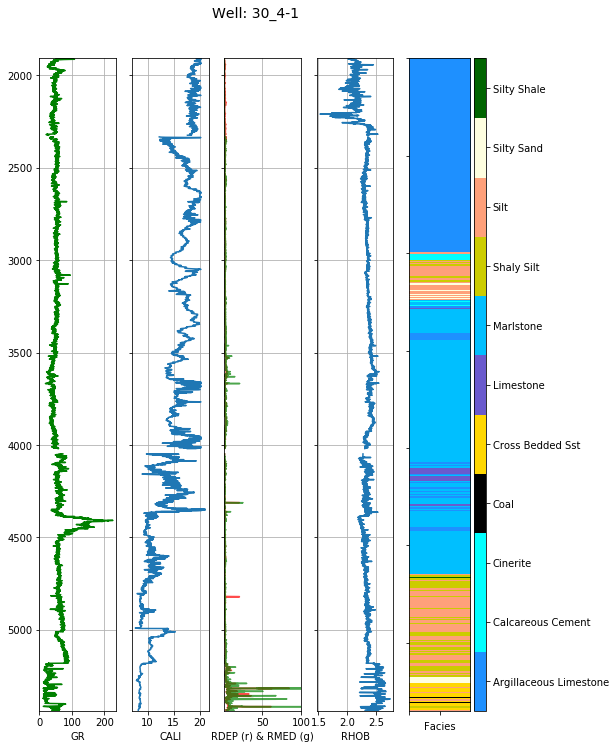

In [26]:
well_name="30_4-1"
logs = xr_all2.sel(Well=well_name).to_dataframe()
logs['DEPT'] = logs['Depth']
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, logs, facies)

In [34]:

def dset_to_nc(dset, f, engine="netcdf4", compression={"zlib": True}):
    if isinstance(dset, xr.DataArray):
        dset = dset.to_dataset(name="data")
    encoding = {k: {"zlib": True} for k in dset.data_vars}
    print(f"saving to {f}")
    dset.to_netcdf(f, engine=engine, encoding=encoding)
    print(f"Wrote {f.stem}.nc size={f.stat().st_size/1e6} M")

In [ ]:
dset_to_nc(dset=xr_all.drop(['geometry']),
          f=interim_locations/'geolink_norge_well_logs.h5')
# .to_netcdf(interim_locations/'geolink_norge_well_logs.h5', 
#                                     format='NETCDF4',
#                                     encoding
                                   
#                                    )

saving to ../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.h5
